# Notebook 02: RNN models and token, character, positional embeddings

In this notebook, we experiment on two RNN models for our sentence classification task.

## 2.1 Motivation for the RNN model

In **notebook 01**, we have seen that our customized token embedding works well in the CNN model. We have also seen that the `universal sentence encoder` token embedding achieves a good accuracy within a reasonable runtime in a dense model. So, what about concatenating them together into a single model? Would this model outperforms all our previous experiments? Moreover, as hinted in **notebook 00**, there are two additional features we have yet explored --- the relative position of each sentence in the abstract (`line_number`) and the characters within the sentences. Can we build a better model using token, character, and positional embeddings? Let's explore the idea in this notebook.



>[Notebook 02: RNN models and token, character, positional embeddings](#scrollTo=MyLKO-km4ehC)

>>[2.1 Motivation for the RNN model](#scrollTo=QQERJXIPjMcK)

>>[2.2 Load and check dependencies](#scrollTo=QRDvGm0d5Dku)

>>>[2.2.1 Load dependencies](#scrollTo=hPlhaFTn5vDi)

>>>[2.2.2 Load and preprocess data](#scrollTo=gHhGAr2d50nf)

>>[2.3 Character, position, and token embeddings](#scrollTo=eX3W5JiIiEOp)

>>>[2.3.1 Character embedding](#scrollTo=zL2awOBYiMBU)

>>>[2.3.2 Positional embedding](#scrollTo=o88VvkE3iTci)

>>>[2.3.3 token embedding](#scrollTo=d-_MZS3TiXgM)

>>>[2.3.4 Batch data for token, character, and positional embeddings](#scrollTo=J4-T-1GaIrSQ)

>>[2.4 Experiments on RNN models](#scrollTo=j8bZ3tKIia9y)

>>>[2.4.1 Model_LSTM: multiple embeddings with LSTM](#scrollTo=evMs4W9YieN8)

>>>[2.4.2 Model_GRU: multiple embeddings with GRU](#scrollTo=lH2KqUD_iscL)

>>[2.5 Model comparison](#scrollTo=Y8wYpedzizCb)



## 2.2 Load and check dependencies

### 2.2.1 Load dependencies

In [1]:
# check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a5fbcef6-4b90-29b5-a2aa-6e17a8c39fc5)


In [2]:
# revert back to a previous version of tensorflow to make sure tensorflow is
# compatible with tensorflow hub.
!pip -q install tensorflow==2.15.0 tensorflow-hub keras==2.15.0;

import tensorflow as tf

print(tf.version.VERSION)

2.15.0


In [3]:
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
!wget https://raw.githubusercontent.com/ZYWZong/ML_Practice_Projects/refs/heads/main/SkimLit_project_practice/SkimLit_utils.py

from SkimLit_utils import *

--2024-12-29 01:10:20--  https://raw.githubusercontent.com/ZYWZong/ML_Practice_Projects/refs/heads/main/SkimLit_project_practice/SkimLit_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8010 (7.8K) [text/plain]
Saving to: ‘SkimLit_utils.py’

SkimLit_utils.py    100%[===================>]   7.82K  --.-KB/s    in 0s      

2024-12-29 01:10:20 (111 MB/s) - ‘SkimLit_utils.py’ saved [8010/8010]



### 2.2.2 Load and preprocess data

In [5]:
!git clone --quiet https://github.com/Franck-Dernoncourt/pubmed-rct.git;

Let's preprocess our data as in **notebook 00**.

In [6]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

# preprocess the data as in notebook 00
train_df, dev_df, test_df = SkimLit_preprocess_master(data_dir)

# create one-hot encoding for tensorflow models
data_all = SkimLit_preprocess_OneHot_NN(train_df, dev_df, test_df)

# batch data_all for fast processing
data_all_batched = SkimLit_batching_data(data_all)

# create category labels as 0,1,2,3,4 for evalutions
label_Encoded = SkimLit_preprocess_EncodedLabels(train_df,dev_df,test_df)

In [7]:
# extract the train and dev data for later use
train_sentences = data_all["train_text"]
dev_sentences = data_all["dev_text"]

train_labels = data_all["train_label"]
dev_labels = data_all["dev_label"]

## 2.3 Character, position, and token embeddings

In this section, we construct the character, position, and token embeddings for the train data.

In [8]:
from tensorflow.keras.layers import TextVectorization

### 2.3.1 Character embedding

Let's build our character embedding. The construction process is similar to that of the customized token embedding in **notebook 01**. First, let's observe the distribution of the character lengths for our train sentences.

In [9]:
train_chars = [" ".join(list(sentence)) for sentence in train_sentences]

# create the dev_chars for later use
dev_chars = [" ".join(list(sentence)) for sentence in dev_sentences]

char_lens = [len(sentence) for sentence in train_sentences]

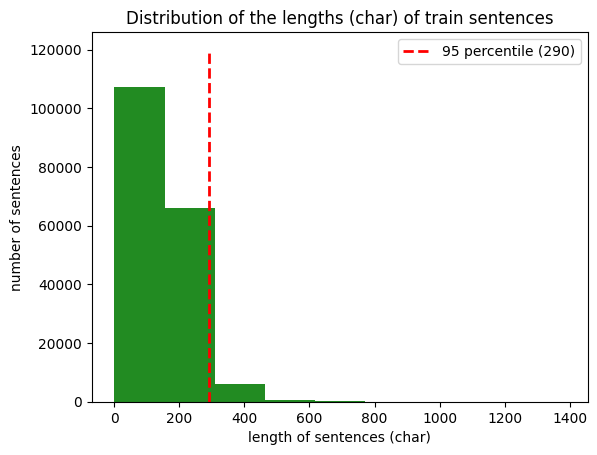

In [10]:
char_Percentile95 = int(np.percentile(char_lens, 95))

height_ = 12e4

plt.hist(char_lens, bins=9, color = "forestgreen")
plt.vlines(char_Percentile95,
           ymin = 0, ymax = height_,
           color = "red", linewidth = 2.0, linestyle = "--",
           label = f"95 percentile ({char_Percentile95})")
plt.xlabel("length of sentences (char)")
plt.ylabel("number of sentences")
plt.title("Distribution of the lengths (char) of train sentences")
plt.legend()
plt.show();

So, an output character vectorization of dimension 290 is reasonable to construct our character embedding.

What about the maximum number of character token? Here, I will let the `TextVectorization` help me to find this out. For fast processing, let's just set the `standardize` parameter to `'strip_punctuation'`.

In [11]:
char_vectorizer = TextVectorization(standardize = 'strip_punctuation',
                                    output_sequence_length=char_Percentile95,
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [12]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"number of unique characters: {len(char_vocab)}")

number of unique characters: 28


So, we have a total of 28 unique characters.

In [13]:
# build the character embedding layer for later use
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                              output_dim=len(char_vocab),
                              mask_zero=False,
                              name="char_embed")

### 2.3.2 Positional embedding

Next, let's build our positional embedding. Positional embedding is likely to yield a better model, because, as we discussed in **notebook 00**, abstracts are typically written in the order of `OBJECTIVE`, `BACKGROUND`, `METHODS`, `RESULTS`, and `CONCLUSIONS`. To construct this embedding, let's observe the distribution of the train sentences' `line_number`.

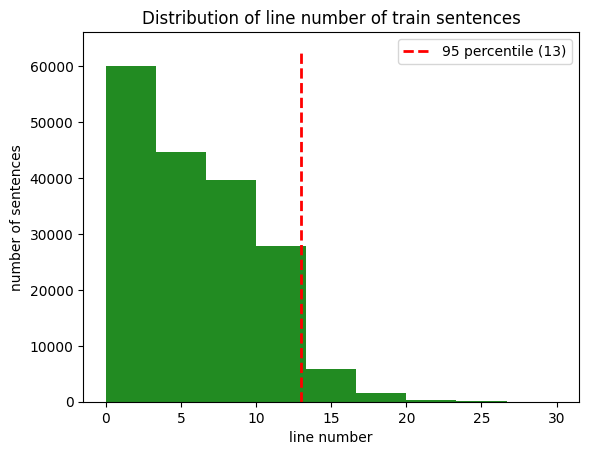

In [14]:
pos_Percentile95 = int(np.percentile(train_df["line_number"], 95))

height_ = 63e3

plt.hist(train_df["line_number"], bins=9, color = "forestgreen")
plt.vlines(pos_Percentile95,
           ymin = 0, ymax = height_,
           color = "red", linewidth = 2.0, linestyle = "--",
           label = f"95 percentile ({pos_Percentile95})")
plt.xlabel("line number")
plt.ylabel("number of sentences")
plt.title("Distribution of line number of train sentences")
plt.legend()
plt.show();

In [15]:
# create one_hot encoding for the position / line number
train_pos_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=pos_Percentile95)
dev_pos_one_hot = tf.one_hot(dev_df["line_number"].to_numpy(), depth=pos_Percentile95)
test_pos_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=pos_Percentile95)

In [16]:
print(train_pos_one_hot)

tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]], shape=(180040, 13), dtype=float32)


### 2.3.3 token embedding

As in **notebook 01**, let's use the `universal sentence encoder` as our token embedding layer.

In [17]:
import tensorflow_hub as hub
tf_hub_USE_embed_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

### 2.3.4 Batch data for token, character, and positional embeddings

In [18]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars,train_pos_one_hot))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

dev_pos_char_token_data = tf.data.Dataset.from_tensor_slices((dev_sentences,dev_chars,dev_pos_one_hot))
dev_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(dev_labels)
dev_pos_char_token_dataset = tf.data.Dataset.zip((dev_pos_char_token_data, dev_pos_char_token_labels))
dev_pos_char_token_dataset = dev_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_token_dataset, dev_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## 2.4 Experiments on RNN models

In this section, we'll build an LSTM and a GRU model each employs token, character, and position embeddings.

### 2.4.1 Model_LSTM: multiple embeddings with LSTM

Our model is a concatenation of three models, one for each token, character, and position embeddings. More specifically, the three models are

1.  Token model: from **notebook 01**, we have seen that the `universal sentence encoder` works well with a dense model. Hence, for the token embedding, we'll continue use a dense model.
2.  Character model: we'll use a bidirectional LSTM model as the orders of characters are important features in a sentence.
3. Position model: we'll use a simple dense model.

In [19]:
# token model
token_USE_input = tf.keras.layers.Input(shape=[], dtype="string", name="token_input")
token_USE_embed = tf_hub_USE_embed_layer(token_USE_input)
token_output = tf.keras.layers.Dense(64, activation="relu")(token_USE_embed)
token_model = tf.keras.Model(inputs=token_USE_input, outputs=token_output)

# char model with bidirectional LSTM
char_input = tf.keras.layers.Input(shape=[1,], dtype="string", name="char_input")
char_vecs = char_vectorizer(char_input)
char_embeds = char_embed(char_vecs)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(char_embeds)
char_model = tf.keras.Model(inputs=char_input, outputs=char_bi_lstm)

# position model
pos_input = tf.keras.layers.Input(shape=[pos_Percentile95,], dtype=tf.int32, name="pos_input")
x = tf.keras.layers.Dense(16, activation="relu")(pos_input)
pos_model = tf.keras.Model(inputs=pos_input,outputs=x)

# concatenate token and char models
token_and_char = tf.keras.layers.Concatenate(name="token_and_char")([token_model.output,
                                                                     char_model.output])

y = tf.keras.layers.Dense(32, activation="relu")(token_and_char)
y = tf.keras.layers.Dropout(0.5)(y) # regularize for better result

# concatenate with position model
y = tf.keras.layers.Concatenate(name="token_char_pos")([pos_model.output,y])

# recall that we have 5 classes
output = tf.keras.layers.Dense(5, activation="softmax", name="output")(y)

model_LSTM = tf.keras.Model(inputs=[token_model.input, char_model.input,pos_model.input],
                            outputs=output, name = "model_LSTM")

In [20]:
model_LSTM.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

In [21]:
model_LSTM.summary()

Model: "model_LSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']

Let's see the model illustratively.

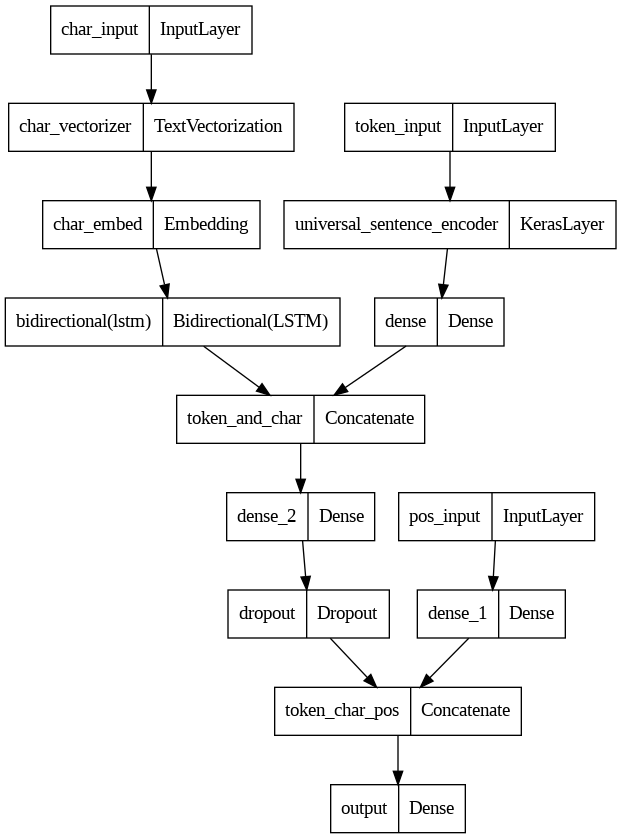

In [22]:
plot_model(model_LSTM, to_file='model_LSTM.png')

Now, let's see how this model performs on our classification task. During the training, let me only validate the fitted model on $10\%$ of our dev data for faster computation.

In [23]:
history_model_LSTM = model_LSTM.fit(train_pos_char_token_dataset,
                                    steps_per_epoch=len(train_pos_char_token_dataset),
                                    epochs=6,
                                    validation_data=dev_pos_char_token_dataset,
                                    validation_steps=int(0.1*len(dev_pos_char_token_dataset)))

Epoch 1/6
5627/5627 [==============================] - 194s 32ms/step - loss: 0.5740 - accuracy: 0.7800 - val_loss: 0.4580 - val_accuracy: 0.8218
Epoch 2/6
5627/5627 [==============================] - 179s 32ms/step - loss: 0.4716 - accuracy: 0.8201 - val_loss: 0.4256 - val_accuracy: 0.8314
Epoch 3/6
5627/5627 [==============================] - 176s 31ms/step - loss: 0.4488 - accuracy: 0.8299 - val_loss: 0.4170 - val_accuracy: 0.8384
Epoch 4/6
5627/5627 [==============================] - 178s 32ms/step - loss: 0.4338 - accuracy: 0.8360 - val_loss: 0.4127 - val_accuracy: 0.8384
Epoch 5/6
5627/5627 [==============================] - 177s 31ms/step - loss: 0.4232 - accuracy: 0.8398 - val_loss: 0.4121 - val_accuracy: 0.8447
Epoch 6/6
5627/5627 [==============================] - 175s 31ms/step - loss: 0.4144 - accuracy: 0.8441 - val_loss: 0.4118 - val_accuracy: 0.8447


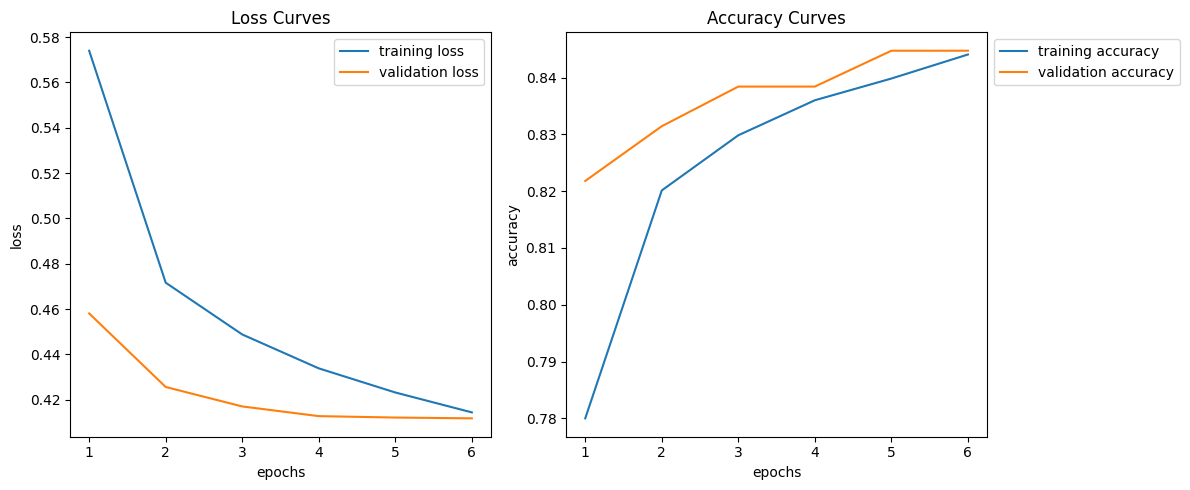

In [24]:
plot_loss_and_accuracy(history_model_LSTM)

From the above plots, we see that our model may start to overfit the training data at epoch 7 if we had continued training. For the purpose of this practice project, let me just stop here at epoch 6. Recall that during the training, we only validated on $10\%$ of the development data. Let's see how the model performs on the full development set.

In [25]:
model_LSTM_pred_probs = model_LSTM.predict(dev_pos_char_token_dataset, verbose=1)

model_LSTM_preds = tf.argmax(model_LSTM_pred_probs, axis=1).numpy()

print(model_LSTM_preds)

945/945 [==============================] - 19s 19ms/step
[0 0 0 ... 4 4 1]


In [26]:
model_LSTM_results = perform_evaluations(y_true=label_Encoded["dev_label"],
                                         y_pred=model_LSTM_preds, model_name = "model_LSTM")

model_LSTM_results_df = pd.DataFrame(model_LSTM_results)

model_LSTM_results_df

,Metric,model_LSTM
0,Accuracy,84.51
1,Precision,84.96
2,Recall,84.51
3,F1-score,84.19


This is our best model so far!

### 2.4.2 Model_GRU: multiple embeddings with GRU

The GRU is a simplified version of LSTM. The GRU runs faster than LSTM and, for most application, yield comparable results to LSTM, which should be the case here. Let's see if this is true.

We build the same model as with the LSTM case, but this time we replace the LSTM unit with the GRU.

In [27]:
# token model
token_USE_input = tf.keras.layers.Input(shape=[], dtype="string", name="token_input")
token_USE_embed = tf_hub_USE_embed_layer(token_USE_input)
token_output = tf.keras.layers.Dense(64, activation="relu")(token_USE_embed)
token_model = tf.keras.Model(inputs=token_USE_input, outputs=token_output)

# char model
char_input = tf.keras.layers.Input(shape=[1,], dtype="string", name="char_input")
char_vecs = char_vectorizer(char_input)
char_embeds = char_embed(char_vecs)
char_bi_GRU = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16))(char_embeds) # replace with GRU
char_model = tf.keras.Model(inputs=char_input, outputs=char_bi_GRU)

# position model
pos_input = tf.keras.layers.Input(shape=[pos_Percentile95,], dtype=tf.int32, name="pos_input")
x = tf.keras.layers.Dense(16, activation="relu")(pos_input)
pos_model = tf.keras.Model(inputs=pos_input,outputs=x)

# concatenate
token_and_char = tf.keras.layers.Concatenate(name="token_and_char")([token_model.output,
                                                                     char_model.output])
y = tf.keras.layers.Dense(32, activation="relu")(token_and_char)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Concatenate(name="token_char_pos")([pos_model.output,y])


output = tf.keras.layers.Dense(5, activation="softmax", name="output")(y)


model_GRU = tf.keras.Model(inputs=[token_model.input, char_model.input,pos_model.input],
                           outputs=output, name = "model_GRU")

In [28]:
model_GRU.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

In [29]:
history_model_GRU = model_GRU.fit(train_pos_char_token_dataset,
                                  steps_per_epoch=len(train_pos_char_token_dataset),
                                  epochs=6,
                                  validation_data=dev_pos_char_token_dataset,
                                  validation_steps=int(0.1*len(dev_pos_char_token_dataset)))

Epoch 1/6
5627/5627 [==============================] - 180s 31ms/step - loss: 0.5781 - accuracy: 0.7811 - val_loss: 0.4473 - val_accuracy: 0.8275
Epoch 2/6
5627/5627 [==============================] - 174s 31ms/step - loss: 0.4702 - accuracy: 0.8215 - val_loss: 0.4196 - val_accuracy: 0.8381
Epoch 3/6
5627/5627 [==============================] - 176s 31ms/step - loss: 0.4459 - accuracy: 0.8318 - val_loss: 0.4158 - val_accuracy: 0.8414
Epoch 4/6
5627/5627 [==============================] - 177s 31ms/step - loss: 0.4302 - accuracy: 0.8379 - val_loss: 0.4121 - val_accuracy: 0.8434
Epoch 5/6
5627/5627 [==============================] - 180s 32ms/step - loss: 0.4209 - accuracy: 0.8413 - val_loss: 0.4067 - val_accuracy: 0.8431
Epoch 6/6
5627/5627 [==============================] - 177s 31ms/step - loss: 0.4115 - accuracy: 0.8447 - val_loss: 0.4090 - val_accuracy: 0.8421


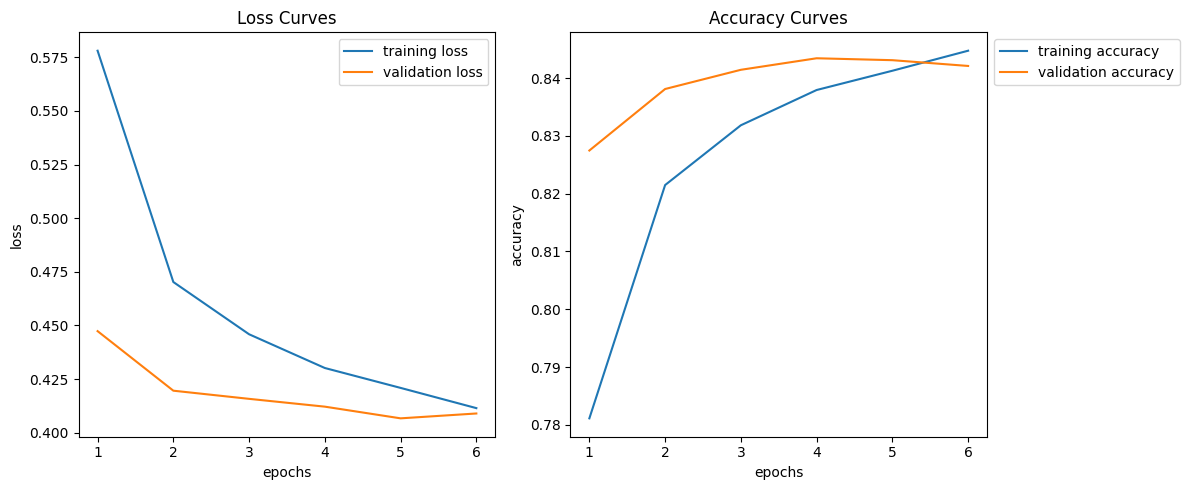

In [30]:
plot_loss_and_accuracy(history_model_GRU)

From the above plot, we see that there is a jump on the validation accuracy. This is a result that I'm only validating on $10\%$ of the development data. For the purpose of this practice project, let me stop training here. Let's see how the model performs on the full development data.

In [31]:
model_GRU_pred_probs = model_GRU.predict(dev_pos_char_token_dataset, verbose=1)

model_GRU_preds = tf.argmax(model_GRU_pred_probs, axis=1).numpy()

print(model_GRU_preds)

945/945 [==============================] - 19s 18ms/step
[0 0 0 ... 4 4 1]


In [32]:
model_GRU_results = perform_evaluations(y_true=label_Encoded["dev_label"],
                                        y_pred=model_GRU_preds, model_name = "model_GRU")

model_GRU_results_df = pd.DataFrame(model_GRU_results)

model_GRU_results_df

,Metric,model_GRU
0,Accuracy,84.43
1,Precision,85.08
2,Recall,84.43
3,F1-score,84.05


## 2.5 Model comparison

In [33]:
joined_df = pd.merge(model_LSTM_results_df, model_GRU_results_df, on="Metric")

joined_df.set_index("Metric", inplace=True)

joined_df

,model_LSTM,model_GRU
Metric,,
Accuracy,84.51,84.43
Precision,84.96,85.08
Recall,84.51,84.43
F1-score,84.19,84.05


We see that the evaluation metrics for the LSTM and the GRU models are quite similar (which is expected as the GRU is a simplified version of LSTM). Recall that our optimizing metric is accuracy and we want all the satisfiying metrics (precision, recall, and F-1) to be at least $70\%$. Based on this criterion, I select the LSTM model as our best RNN model.